In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")
# look at the dataset
#log_pr.head()
# Check the log-prices of the 10 assets
#log_pr.plot(figsize=(12, 8))

# Pre-processing
# Differencing log prices to obtain stationary series
#log_pr_diff = log_pr.diff()
#log_pr_diff.plot(figsize=(12, 8))

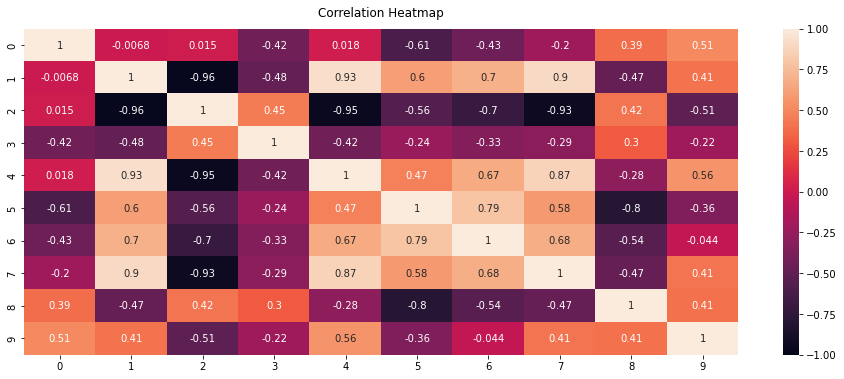

In [3]:
# plot correlation heatmap to see how to bundle the stocks
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(log_pr.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [8]:
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA
from statsmodels.multivariate.factor import Factor
# two groups (1,2,4,7) and (0,5,6,8) and two alone 3 & 9
group1 = log_pr[[1,2,4,7]]
group2 = log_pr[[0,5,6,8]]
stock1 = log_pr[3]
stock9 = log_pr[9]

In [12]:
group1.iloc[:1440]

,1,2,4,7
timestamp,,,,
2021-07-01 00:00:00,-0.002754,-0.001690,0.002195,0.000492
2021-07-01 00:01:00,-0.001334,0.000652,0.000969,0.001095
2021-07-01 00:02:00,0.001095,0.001293,-0.003068,0.000172
2021-07-01 00:03:00,0.000931,0.001274,-0.002457,0.000216
2021-07-01 00:04:00,0.001134,0.001266,-0.003706,0.000299
...,...,...,...,...
2021-07-01 23:55:00,0.031107,-0.001711,0.011198,0.003708
2021-07-01 23:56:00,0.031258,-0.002029,0.009688,0.003480
2021-07-01 23:57:00,0.032155,-0.003083,0.009226,0.003596


In [25]:
fa_model1 = Factor(group1.iloc[:10000],n_factor=2)
fa_model1.corr

array([[ 1.        , -0.88304285,  0.94069829, -0.60402478],
       [-0.88304285,  1.        , -0.88771226,  0.63070596],
       [ 0.94069829, -0.88771226,  1.        , -0.53745671],
       [-0.60402478,  0.63070596, -0.53745671,  1.        ]])

In [30]:
pca_model1 = PCA(group1.iloc[:10000],standardize=False,demean=False)
pca_model1.eigenvals.cumsum()/pca_model1.eigenvals.sum()

0    0.865623
1    0.955424
2    0.986303
3    1.000000
Name: eigenvals, dtype: float64

In [29]:
pca_model2 = PCA(group2.iloc[:10000],standardize=False,demean=False)
pca_model2.eigenvals.cumsum()/pca_model2.eigenvals.sum()

0    0.759192
1    0.979344
2    0.991636
3    1.000000
Name: eigenvals, dtype: float64

In [ ]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [ ]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

In [ ]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [ ]:
# Correlation for every asset

r_fwd.corrwith(r_hat)

In [ ]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]